<a href="https://colab.research.google.com/github/laggyperson/URAP-Colab-ML-Notebooks/blob/main/Traffic_Prediction_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Experiment
# Will split the inputs and labels of the features based on initial parameters
def split_window(features):
  inputs = features[:, slice(0, 7), :]
  labels = features[:, slice(8, 10), :]

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, 7, None])
  labels.set_shape([None, 2, None])

  return (inputs, labels)

data = []
start, stop = 0, 5
for _ in range(50):
  data.append(np.arange(start, stop))
  start = stop
  stop += 5

data = np.array(data)
print(data.shape)

ds = keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=10,
        sequence_stride=5,
        shuffle=False,
        batch_size=32,)

ds = ds.map(split_window)

# for feature, label in ds.take(2):
#   print(np.array(feature), "=>", np.array(label))

NameError: ignored

# About
These are the models/experiments I will be running on the Sumo collected data.

Idea on Data:
* https://stats.stackexchange.com/questions/305863/how-to-train-lstm-model-on-multiple-time-series-data
* https://datascience.stackexchange.com/questions/67171/can-i-use-lstm-models-to-evaluate-multiple-independent-time-series
* https://medium.com/@kavyamalla/extending-tensorflows-window-generator-for-multiple-time-series-8b15eba57858

## Idea 1:
Seems like I batch together multiple vehicles and train it through the entire series. Then to test within the cycle, run a partial window through new vehicles and check the labels??

## Idea 2:
I am collecting data into `(# of vehicles across all simulations, # of time steps, data)`. I originally was normalizing according to each vehicle, but I don't think I should do that since the relative amount of traffic should be learned by normalizing across all simulation data.

I will then create the normal preprocessing head and then combine that into a model with a compile function. There will be no processing beforehand.

To further organize the data, I will split the data into 70% training, 20% validation, and 10% test. This means the first 70% of the time series data is used, so on so forth.

The way the data is organized is as follows:
Say each vehicle in each simulation has a time series that looks like
$[f_0, ..., f_{2401}]$ where $f_i$ is a vector of all the features at a certain time step.

Say that my window is 50 time steps total, split into 25 inputs and 25 labels.
$$[0, ..., 24] \rightarrow [25, ...,49]$$
If I take a stride of 25 and batch 32 sequences together, the data will look as follows:

**Batch 1:**

$[f_0, ..., f_{24}] \rightarrow [f_{25}, ..., f_{49}]$

$[f_{25}, ..., f_{49}] \rightarrow [f_{50}, ..., f_{74}]$

$\qquad \qquad \qquad \vdots$

$[f_{775}, ..., f_{799}] \rightarrow [f_{800}, ..., f_{824}]$

**Batch 2:**

$[f_{800}, ..., f_{824}] \rightarrow [f_{825}, ..., f_{849}]$

$\qquad\qquad\qquad \vdots$

**Batch 3:**

$\vdots$

After shuffling, each `input, label` pair will be shuffled around. The state of the LSTM will be reset after each batch.

This data will be normalized all together, so there is a sense of relative amounts of traffic that differs in every simulation

##Issue:
An issue that needs to be addressed is the changing destinations. It is possible that the LSTM will become confused when in the middle of an input the car suddenly switches a destination, meaning the model suddenly has to disregard the previous destination and its associated values.

### Idea 1:
Split the vehicle time series data into separate sequences that end when the vehicle reaches the destination. This would lead to variable window and input lengths that will not be padded because the lengths may vary a lot.

### Idea 2:
Batch the data the same way as before, but remove any inputs where the destination changes. Filtering the data seems to be possible.

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers

# Loading the Data

In [3]:
g16_100v_noLC_shortTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_100v_noLC.nc")
g16_100v_noLC_shortTL_arr = g16_100v_noLC_shortTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_100v_LC_shortTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_100v_LC.nc")
g16_100v_LC_shortTL_arr = g16_100v_LC_shortTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_100v_LC_longTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_100v_LC_longTL.nc")
g16_100v_LC_longTL_arr = g16_100v_LC_longTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_50v_LC_longTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_50v_LC_longTL.nc")
g16_50v_LC_longTL_arr = g16_50v_LC_longTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_200v_LC_longTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_200v_LC_longTL.nc")
g16_200v_LC_longTL_arr = g16_200v_LC_longTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

# List of all arrays
arrs = [g16_100v_noLC_shortTL_arr, g16_100v_LC_shortTL_arr, g16_100v_LC_longTL_arr, g16_50v_LC_longTL_arr, g16_200v_LC_longTL_arr]

In [11]:
arrs[0].data.shape

(100, 2401, 22)

In [ ]:
# Concatenating
all_xarr = xr.concat(arrs, dim="Veh IDs")
all_xarr["Veh IDs"].data

# Preprocessing Head

Since I have 550 time series data, there will be 550 numeric preprocessing heads because every times series has their own mean and standard deviation.

In [6]:
# Creating inputs
inputs = {}
categorical_vars = ["Traffic Light State", "Destination Edge", "Destination Reached"] # Last one is binary, but is "y" and "n", so will convert it

for label in g16_100v_noLC_shortTL_arr["Data Labels"].data:
  dtype = tf.float32
  if label in categorical_vars:
    dtype = tf.string
  inputs[label] = keras.Input(shape=(1,), name=label, dtype=dtype)

In [30]:
# Concatenating all time series together for now to normalize
single_ts = all_xarr.stack(totalTime=("Time", "Veh IDs"))
single_ts = single_ts.transpose("totalTime", "Data Labels")

In [31]:
# Checking this time series
single_ts.data.shape

(1320550, 22)

In [33]:
# Handling numerical columns
# Putting together numeric input layers
numeric_inputs = {label:input for label, input in inputs.items() if input.dtype==tf.float32}

# Concatenating the layers
temp = layers.Concatenate()(list(numeric_inputs.values()))

norm = layers.Normalization()
norm.adapt(single_ts.sel({"Data Labels": list(numeric_inputs.keys())}).data.astype(float))
all_numeric_inputs = norm(temp)

In [9]:
# Categorical variables
cat_vars = [] # (# of categorical vars)
for label in categorical_vars:
  # Will only need to use one time series for creating this: more efficient (I believe)
  lookup = layers.StringLookup(vocabulary=np.unique(arrs[0].sel({"Data Labels":label}).data))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  tmp = lookup(inputs[label])
  tmp = one_hot(tmp)
  cat_vars.append(tmp)

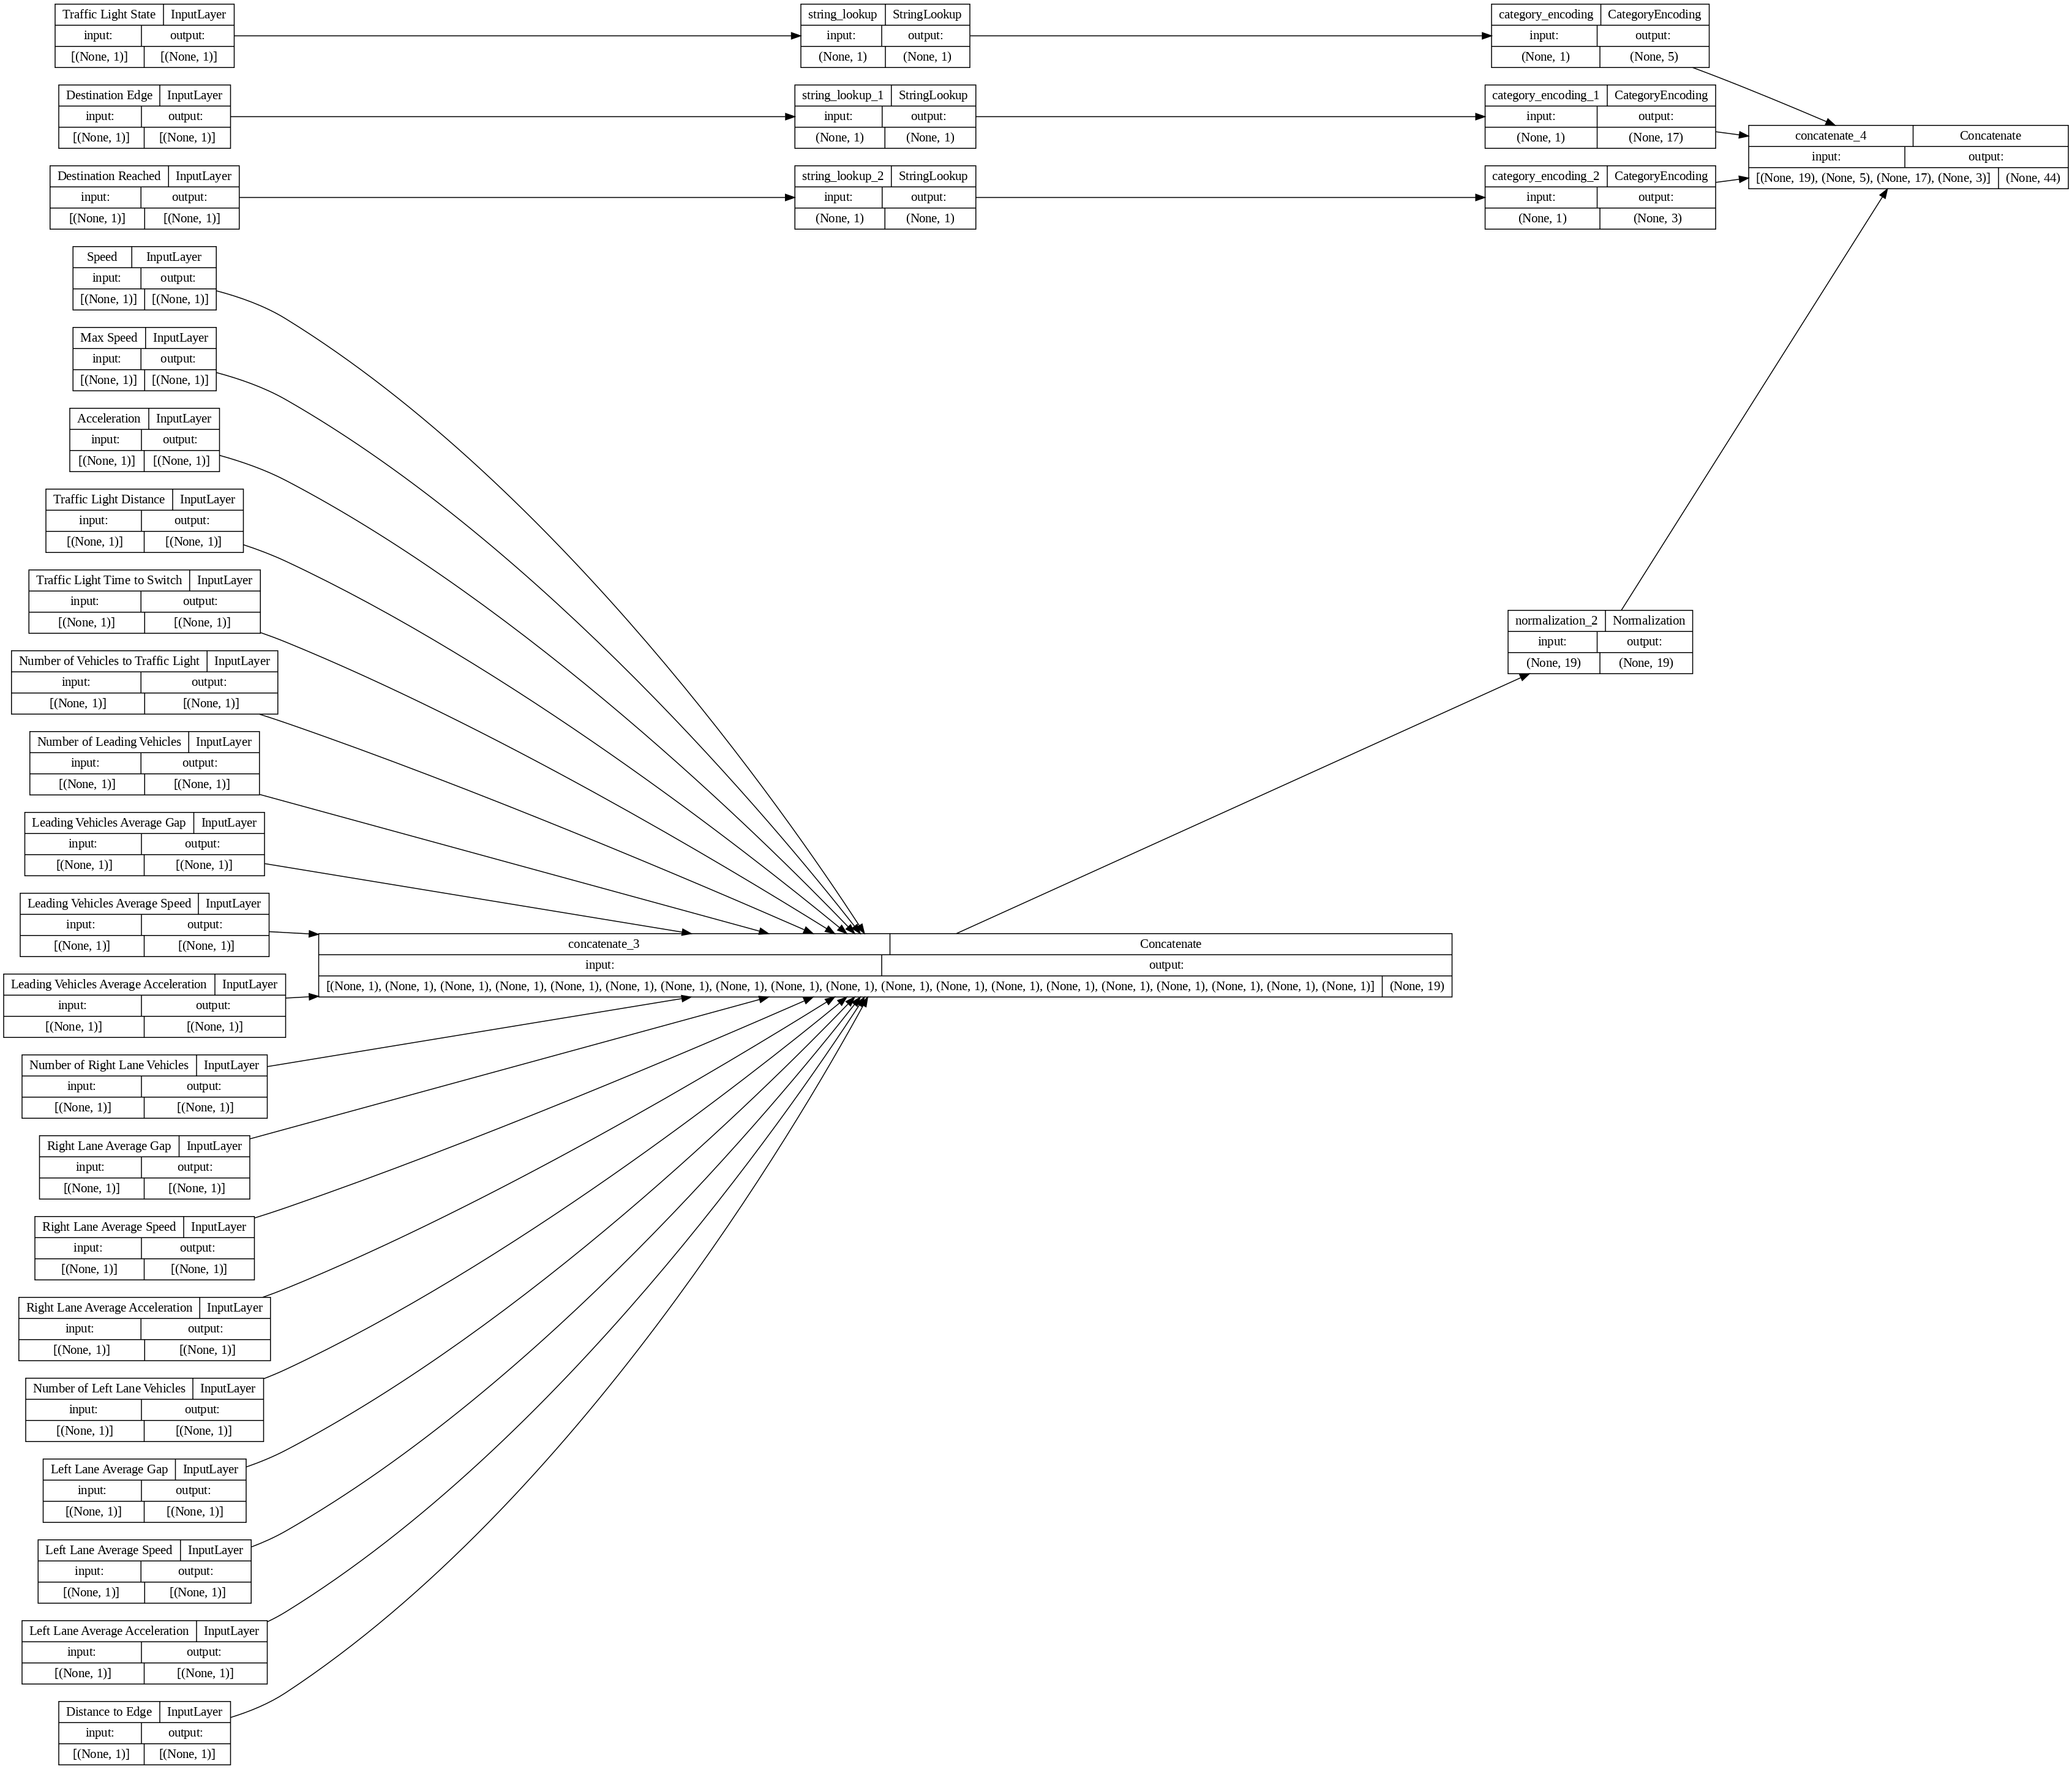

In [34]:
# Creating the processing heads
preprocessing_list = [all_numeric_inputs] + cat_vars
preprocessing_cat = layers.Concatenate()(preprocessing_list)

preprocessing_head = keras.Model(inputs, preprocessing_cat)

# Printing one out to check structure
tf.keras.utils.plot_model(model=preprocessing_head, rankdir="LR", dpi=108, show_shapes=True)

In [ ]:
# Splitting the Data into training and test sets
# Distribution: 70% training, 20% validation, 10% test

steps = len(preprocess_ts[0])
# Slices
train_slice = slice(0, int(0,7 * steps))
validate_slice = slice(int(0.7 * steps), int(0.9 * steps))
test_slice = slice(int(0.9 * steps), None)
# Splitting each individual set
preprocess_train_ts = preprocess_ts.map(lambda x: x[train_slice])
preprocess_validate_ts = preprocess_ts.map(lambda x: x[validate_slice])
preprocess_test_ts = preprocess_ts.map(lambda x: x[test_slice])

# Windowing + Batching

In [23]:
# Creating a Window class

class WindowGenerator():
  def __init__(self, input_width, label_width, shift, stride, xarr,
               train_data, val_data, test_data, label_columns=None):
    # Windows intialized with data
    self.train_data = train_data
    self.val_data = val_data
    self.test_data

    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.stride = stride
    self.xarr = xarr

    if label_columns is not None:
      self.label_column_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    else:
      self.label_column_indices = {name: i for i, name in enumerate(self.xarr["Data Labels"].data)}
    self.label_columns = self.label_column_indices.keys()

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_window(self, features):
    inputs = features[:, self.input_slice, :] # (batch, time, data)
    labels = features[:, self.labels_slice, :]
    labels = tf.stack(
        [labels[:, :, self.label_column_indices[name]] for name in self.label_columns],
        axis=-1) # For if only specific features used

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def makeDataset(self, data):
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=128,)
    return ds.map(self.split_window)

  def plot(self, model=None, plot_col='Distance to Destination', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  @property
  def train(self):
    return self.make_dataset(self.training_data)

  @property
  def val(self):
    return self.make_dataset(self.val_data)

  @property
  def test(self):
    return self.make_dataset(self.test_daata)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

# Model Template

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Model #1: Simple LSTM, Single-Shot Prediction

# Model #2: Simple LSTM, Autoregressive Prediction

# Model #3: Denser LSTM, Single-Shot Prediction

# Model #4: Denser LSTM, Autoregressive Prediction

# Model #5: Transformer